In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 as sql3
import random

random.seed(1000)
np.random.seed(1000)

sns.set(style="darkgrid")
ROOT_PATH="C:/Users/moshe/Documents/projectML/p1"
DATA_PATH = "%s/data/raw" % ROOT_PATH
DB_FILE = "%s/hairsalon.db" % DATA_PATH
def readSQL(query):
    import pandas as pd
    import sqlite3 as sql3
    db = sql3.connect(DB_FILE)
    df = pd.read_sql_query(query, db)
    db.close()
    return(df)

db=sql3.connect(DB_FILE)

In [62]:
def readXy(query):
    df=readSQL(query)
    for c in df.columns:
        if df[c].nunique() < 14:
            df[c] = df[c].astype('category')
    df=df.reindex(np.random.permutation(df.index)).reset_index(drop=True)
    X=df.loc[:,df.columns[1:]]
    y=df['noshowflag']
    return X,y

query="""select * from rtest"""
Xtest,ytest=readXy(query)
query="""select * from rtrain"""
Xtrain,ytrain=readXy(query)
query="""select * from rdev"""
Xdev,ydev=readXy(query)
Xftrain=pd.concat([Xtrain,Xdev])
yftrain=pd.concat([ytrain,ydev])
print([len(Xtrain),len(Xdev),len(Xftrain)])
Xftrain=Xftrain.reset_index(drop=True)
yftrain=yftrain.reset_index(drop=True)
test_fold1=np.full(len(Xtrain),-1)
test_fold2=np.full(len(Xdev),0)
test_fold=np.append(test_fold1,test_fold2)

[1814, 336, 2150]


In [63]:
from sklearn.model_selection import PredefinedSplit
ps = PredefinedSplit(test_fold)
ps.get_n_splits()


1

In [65]:
# Number of boosting rounds
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 950, num = 10)]
# Number of features to consider at every split
max_features = [3,'sqrt']
# Maximum number of levels in tree
max_depth = [2,3,4,5,8,10]
# Minimum number of samples required to split a node
min_samples_split = [2,5,8]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,5]
#Criterion
criterion=['friedman_mse','mse','mae']
#learning rate
learning_rate=[0.05,0.1,0.15,0.2,0.3,0.5,1]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'criterion': criterion,
               'learning_rate':learning_rate
              }

print(random_grid)

{'n_estimators': [50, 150, 250, 350, 450, 550, 650, 750, 850, 950], 'max_features': [3, 'sqrt'], 'max_depth': [2, 3, 4, 5, 8, 10], 'min_samples_split': [2, 5, 8], 'min_samples_leaf': [1, 2, 5], 'criterion': ['friedman_mse', 'mse', 'mae'], 'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 1]}


In [66]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
gb = GradientBoostingClassifier(random_state=100)

gb_random = RandomizedSearchCV(estimator = gb, param_distributions = random_grid, n_iter = 250, cv = ps.split(Xftrain,yftrain),verbose=2, random_state=100, n_jobs = -1)
# Fit the random search model
gb_random.fit(Xftrain, yftrain)

Fitting 1 folds for each of 250 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  7.2min finished


RandomizedSearchCV(cv=<generator object PredefinedSplit.split at 0x0000023AF8B4A468>,
          error_score='raise-deprecating',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=250, n_jobs=-1,
          param_distributions={'n_estimators': [50, 150, 250, 350, 450, 550, 650, 750, 850, 950], 'max_features': [3, 'sqrt'], 'max_depth': [2, 3, 4, 5, 8, 10], 'min_samples_split': [2, 5, 8], 'min_samples_leaf': [1, 2, 5], 'criterion': ['friedman_mse', 'mse', 'mae'], 'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 1]},
          pre_dispatch='2*n_jobs', random_state=100, refit=True,
     

In [67]:
gb_random.best_params_

{'n_estimators': 950,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 3,
 'max_depth': 10,
 'learning_rate': 0.05,
 'criterion': 'mae'}

In [68]:
def evaluate(model, test_features, test_labels,text1):
    accuracy2=100*model.score(test_features,test_labels)
    predictions = model.predict(test_features)
    array1=[1]*len(test_features)
    errors = abs(predictions.astype(int) - test_labels.astype(int).values)
    TP=sum(np.logical_and(predictions.astype(int)==1,errors==0))
    TN=sum(np.logical_and(predictions.astype(int)==0,errors==0))
    FP=sum(np.logical_and(predictions.astype(int)==1,errors==1))
    FN=sum(np.logical_and(predictions.astype(int)==0,errors==1))
    
    
    
    Precision=100*(TP)/(TP+FP)
    Recall=100*(TP/(TP+FN))
    accuracy=100*(TP+TN)/(TP+FP+FN+TN)
    F1=(2*Recall*Precision)/(Recall+Precision)
    print('Model Performance '+text1)
    print(['True Positive ',TP,'False Positive',FP,'True Negative ',TN,'False Negative',FN])
    print('Precision = {:0.2f}%.'.format(Precision))
    print('Recall = {:0.2f}%.'.format(Recall))
    print('F1 = {:0.2f}%.'.format(F1))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return Precision

#### Run base model

In [92]:
base_model = GradientBoostingClassifier(random_state=1000,max_depth=5)
base_model.fit(Xtrain, ytrain)
x=evaluate(base_model, Xdev, ydev,'base model checked against dev')

Model Performance base model checked against dev
['True Positive ', 11, 'False Positive', 30, 'True Negative ', 286, 'False Negative', 9]
Precision = 26.83%.
Recall = 55.00%.
F1 = 36.07%.
Accuracy = 88.39%.


In [93]:
base_precision = evaluate(base_model, Xtest, ytest,'base model checked against test')

Model Performance base model checked against test
['True Positive ', 14, 'False Positive', 26, 'True Negative ', 385, 'False Negative', 24]
Precision = 35.00%.
Recall = 36.84%.
F1 = 35.90%.
Accuracy = 88.86%.


#### Compare fine-tunned model


In [71]:
best_random = gb_random.best_estimator_
random_precision = evaluate(best_random, Xtest, ytest,'best random checked against test')

Model Performance best random checked against test
['True Positive ', 10, 'False Positive', 6, 'True Negative ', 405, 'False Negative', 28]
Precision = 62.50%.
Recall = 26.32%.
F1 = 37.04%.
Accuracy = 92.43%.


In [72]:
print('Precision Improvement of {:0.2f}%.'.format( 100 * (random_precision - base_precision) / base_precision))

Precision Improvement of 78.57%.


Grid search: we decide which parameters and how (not randomly)

In [76]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid 
# Number of boosting rounds
n_estimators = [100,300,500,700,900,1100]
# Number of features to consider at every split
max_features = [3,'sqrt']
# Maximum number of levels in tree
max_depth = [3,5,10,12]
# Minimum number of samples required to split a node
min_samples_split = [2,5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2]
#Criterion
criterion=['friedman_mse','mse']
#learning rate
learning_rate=[0.05,0.1,0.15,0.25,0.5]
#warm_start
warm_start=[True]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'criterion': criterion,
               'learning_rate':learning_rate,
              'warm_start':warm_start
              }

print(param_grid)
# Create a based model
gb = GradientBoostingClassifier(random_state=100)
# Instantiate the grid search model

grid_search = GridSearchCV(estimator = gb, param_grid = param_grid, cv = ps.split(Xftrain,yftrain), n_jobs = -1, verbose = 2)

{'n_estimators': [100, 300, 500, 700, 900, 1100], 'max_features': [3, 'sqrt'], 'max_depth': [3, 5, 10, 12], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'criterion': ['friedman_mse', 'mse'], 'learning_rate': [0.05, 0.1, 0.15, 0.25, 0.5], 'warm_start': [True]}


In [77]:
# Fit the grid search to the data
grid_search.fit(Xftrain, yftrain)

Fitting 1 folds for each of 1920 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   51.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed:  9.5min finished


GridSearchCV(cv=<generator object PredefinedSplit.split at 0x0000023AF8B4AD58>,
       error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [100, 300, 500, 700, 900, 1100], 'max_features': [3, 'sqrt'], 'max_depth': [3, 5, 10, 12], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'criterion': ['friedman_mse', 'mse'], 'learning_rate': [0.05, 0.1, 0.15, 0.25, 0.5], 'warm_start': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [80]:
grid_search.best_params_

{'criterion': 'mse',
 'learning_rate': 0.15,
 'max_depth': 12,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 300,
 'warm_start': True}

In [81]:
best_grid = grid_search.best_estimator_
grid_precision = evaluate(best_grid, Xtest, ytest,'best searched grid checked against test')

Model Performance best searched grid checked against test
['True Positive ', 8, 'False Positive', 6, 'True Negative ', 405, 'False Negative', 30]
Precision = 57.14%.
Recall = 21.05%.
F1 = 30.77%.
Accuracy = 91.98%.


In [82]:
print('Precision Improvement of {:0.2f}%.'.format( 100 * (grid_precision - base_precision) / base_precision))

Precision Improvement of 63.27%.


0.7765719042130874 0.6921820975797157 0.7689524907158406


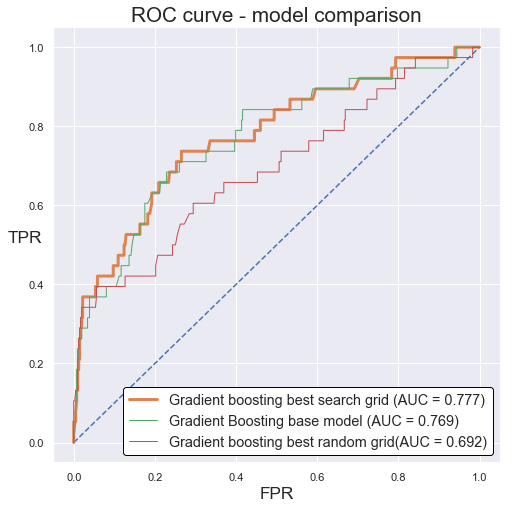

In [87]:
from sklearn.metrics import roc_curve, auc
pred1 = best_grid.predict_proba(Xtest)
fpr1, tpr1, thresholds = roc_curve(ytest.values, pred1[:,1],pos_label='1')

pred2 = best_random.predict_proba(Xtest)
fpr2, tpr2, thresholds = roc_curve(ytest.values, pred2[:,1],pos_label='1')

pred3 = base_model.predict_proba(Xtest)
fpr3, tpr3, thresholds = roc_curve(ytest.values, pred3[:,1],pos_label='1')

import matplotlib.pyplot as plt
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)


x=np.linspace(0,1)
y=x

print(roc_auc1,roc_auc2,roc_auc3)
fig, ax = plt.subplots(figsize=(8, 8))


plt.title("ROC curve - model comparison",fontsize='xx-large')
plt.xlabel("FPR",fontsize='x-large')
plt.ylabel("TPR",rotation=0,fontsize='x-large')
plt.plot(x,y,linestyle='--')
plt.plot(fpr1, tpr1, lw=3, label='Gradient boosting best search grid (AUC = %0.3f)' %roc_auc1)
plt.plot(fpr3, tpr3, lw=1, label='Gradient Boosting base model (AUC = %0.3f)' %roc_auc3)
plt.plot(fpr2, tpr2, lw=1, label='Gradient boosting best random grid(AUC = %0.3f)' %roc_auc2)
plt.legend(loc='best',fontsize='large',framealpha=1,fancybox=True,edgecolor='Black',facecolor='White')
plt.show()